# Dealing with outliers

This covid case for outlier identification is from [Python Data Cleaning Cookbook: Prepare your data for analysis with pandas, NumPy, Matplotlib, scikit-learn, and OpenAI 2nd ed](https://www.amazon.com/Python-Data-Cleaning-Cookbook-insights/dp/1803239875), by Michael Walker
## Identifying outliers
### Summary statistics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

covid_totals = pd.read_csv("data/covidtotals.csv")

# set up the cumulative and demographic columns
total_vars = ['iso_code','location', 'total_cases', 'total_deaths', 'total_cases_pm', 'total_deaths_pm']

covid_totals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   iso_code         231 non-null    object 
 1   lastdate         231 non-null    object 
 2   location         231 non-null    object 
 3   total_cases      231 non-null    float64
 4   total_deaths     231 non-null    float64
 5   total_cases_pm   231 non-null    float64
 6   total_deaths_pm  231 non-null    float64
 7   population       231 non-null    int64  
 8   pop_density      209 non-null    float64
 9   median_age       194 non-null    float64
 10  gdp_per_capita   191 non-null    float64
 11  hosp_beds        170 non-null    float64
 12  vac_per_hund     13 non-null     float64
 13  aged_65_older    188 non-null    float64
 14  life_expectancy  227 non-null    float64
 15  hum_dev_ind      187 non-null    float64
 16  region           231 non-null    object 
dtypes: float64(12), 

In [2]:
# Get descriptive statistics for the COVID-19 case data.
# Create a DataFrame with just the key case data:
covid_totals_only = covid_totals[total_vars].copy()
covid_totals_only.describe()

,total_cases,total_deaths,total_cases_pm,total_deaths_pm
count,2.310000e+02,2.310000e+02,231.000000,231.000000
mean,3.351599e+06,3.021420e+04,206177.794623,1261.778390
std,1.148321e+07,1.047789e+05,203858.096252,1314.981529
min,4.000000e+00,0.000000e+00,354.487000,0.000000
25%,2.567150e+04,1.775000e+02,21821.863000,141.177000
50%,1.914960e+05,1.937000e+03,133946.251000,827.046000
75%,1.294286e+06,1.415000e+04,345689.831000,1997.513000
max,1.034368e+08,1.127152e+06,763475.441000,6507.656000


In [3]:
# Show more detailed percentile data.
# We indicate that we only want to do this for numeric values so that the location column is skipped:
covid_totals_only.quantile(np.arange(0.0, 1.1, 0.1),
                           numeric_only=True)

,total_cases,total_deaths,total_cases_pm,total_deaths_pm
0.0,4.0,0.0,354.487,0.000
0.1,8359.0,31.0,3138.575,32.885
0.2,17181.0,126.0,10885.737,105.298
0.3,38008.0,294.0,35834.604,210.509
0.4,74129.0,844.0,86126.235,498.789
0.5,191496.0,1937.0,133946.251,827.046
0.6,472755.0,4384.0,220429.369,1251.299
0.7,1041111.0,9646.0,293737.443,1697.571
0.8,1877065.0,21218.0,416608.106,2271.676
0.9,5641992.0,62288.0,512388.401,3155.939


In [4]:
# You can also check head() and tail() after sort_values() to check the smallest values and largest values
covid_totals_only['total_cases'].sort_values().head()

163       4.0
224      26.0
208      80.0
150     993.0
137    1403.0
Name: total_cases, dtype: float64

In [5]:
# Skewness and kurtosis describe how symmetrical the distribution is and how fat the tails of the distribution are, respectively. Both measures, for total_cases and total_deaths, are significantly higher than we would expect if our variables were distributed normally:
covid_totals_only.skew(numeric_only=True)

total_cases        6.307179
total_deaths       7.098945
total_cases_pm     0.834903
total_deaths_pm    1.252925
dtype: float64

In [6]:
# Note about kurtosis: There are two common definition of kurtosis:
# (1) Pearson Kurtosis: Normal distribution has kurtosis = 3
# (2) Fisher (Excess) Kurtosis: Normal distribution has kurtosis = 0. This subtracts 3 from Pearson’s value
# Pandas returns Fisher’s (excess) kurtosis.
covid_totals_only.kurt(numeric_only=True)

total_cases        47.080248
total_deaths       61.727944
total_cases_pm     -0.428060
total_deaths_pm     1.256217
dtype: float64

### Visual detection
Two options: histogram or boxplots
#### Histogram


<Axes: ylabel='Frequency'>

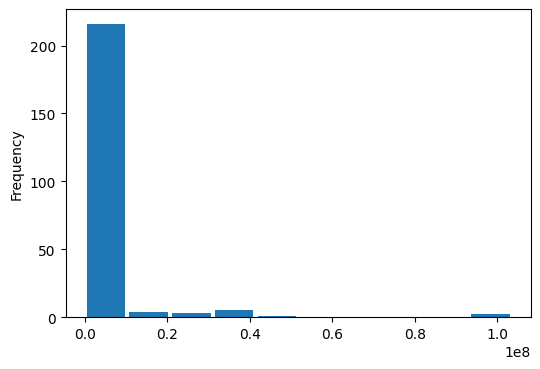

In [13]:
# Plot one histogram
covid_totals_only['total_cases'].plot.hist(bins=10, rwidth=0.9, figsize=(6, 4))

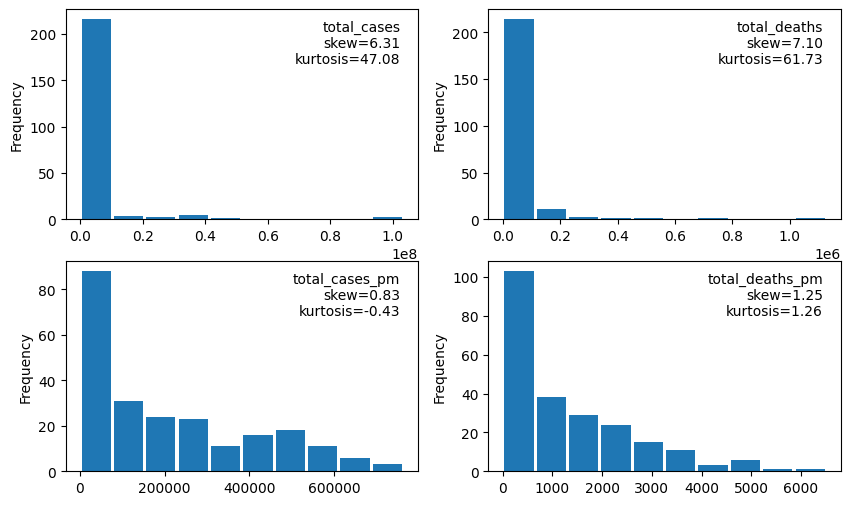

In [14]:
# or you could plot them in one big plot

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

for col, ax in zip(total_vars[2:], axes.flat):
    covid_totals_only[col].plot.hist(bins=10, rwidth=0.9, ax=ax)
    ax_title = (f"{col}\n"
                f"skew={covid_totals_only[col].skew(numeric_only=True):.2f}\n"
                f"kurtosis={covid_totals_only[col].kurt(numeric_only=True):.2f}")
    ax.text(x=0.95, y=0.95, s=ax_title,
            ha='right', va='top', transform=ax.transAxes)


#### Boxplot
[Pandas box plot](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.boxplot.html):
Make a box-and-whisker plot from DataFrame columns, optionally grouped by some other columns. A box plot is a method for graphically depicting groups of numerical data through their quartiles. The box extends from the Q1 to Q3 quartile values of the data, with a line at the median (Q2). The whiskers extend from the edges of box to show the range of the data. By default, they extend no more than 1.5 * IQR (IQR = Q3 - Q1) from the edges of the box, ending at the farthest data point within that interval. Outliers are plotted as separate dots.

<Axes: >

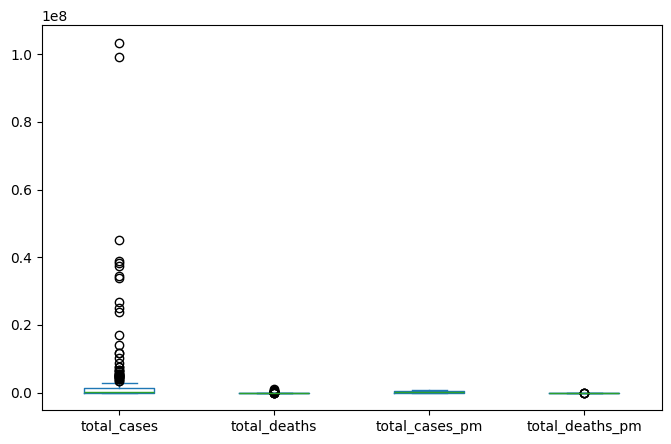

In [15]:

covid_totals_only.plot.box(figsize=(8, 5))

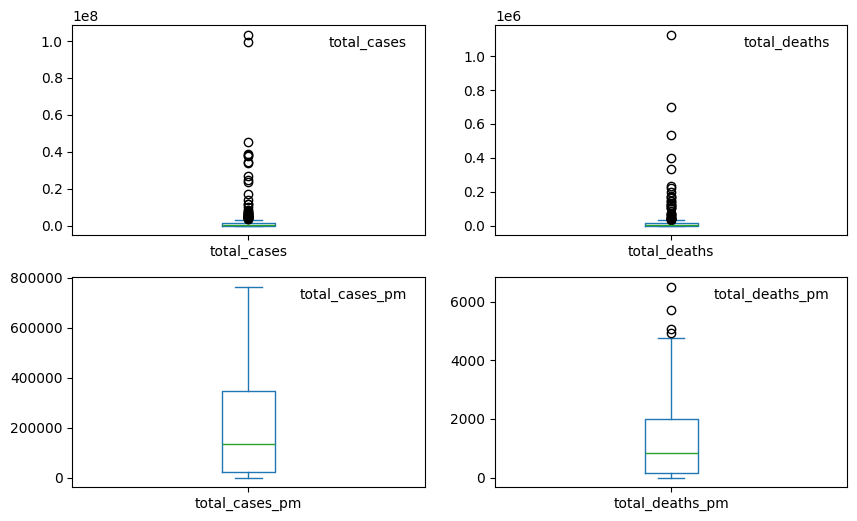

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

for col, ax in zip(total_vars[2:], axes.flat):
    covid_totals_only[col].plot.box(ax=ax)
    ax.text(x=0.95, y=0.95, s=col,
            ha='right', va='top', transform=ax.transAxes)

## Interquartile Range (IQR) Method
### Identify outliers using IQR with one column

In [18]:
third_quartile, first_quartile = covid_totals_only['total_cases'].quantile(0.75), covid_totals_only.total_cases.quantile(0.25)
inter_quartile_range = 1.5 * (third_quartile - first_quartile)
outlier_high, outlier_low = inter_quartile_range + third_quartile, first_quartile - inter_quartile_range
print(f"The low fence and high fence for total_cases is:\n{outlier_low} <--> {outlier_high}")


The low fence and high fence for total_cases is:
-1877250.25 <--> 3197207.75


### Write util functions to identify all outliers in each column

In [19]:
def find_outliers_in_one_column(s: pd.Series) -> pd.Series:
    q3, q1 = s.quantile(0.75), s.quantile(0.25)
    iqr = q3-q1
    high_bound, low_bound = 1.5*iqr + q3, q1 - 1.5*iqr
    return (s < low_bound) | (s > high_bound)

In [20]:
find_outliers_in_one_column(covid_totals_only['total_cases'])

0      False
1      False
2      False
3      False
4      False
       ...  
226     True
227    False
228    False
229    False
230    False
Name: total_cases, Length: 231, dtype: bool

In [21]:

print("Number of outliers using IQR method:")
for col in total_vars[2:]:
    try:
        outliers = find_outliers_in_one_column(covid_totals_only[col]).sum()
        print(f"{col}: {outliers}")
    except Exception as e:
        pass

Number of outliers using IQR method:
total_cases: 39
total_deaths: 33
total_cases_pm: 0
total_deaths_pm: 4


In [ ]:
# Label each row if at least one of four numerical variables is an outlier
from functools import reduce

numerical_vars = total_vars[2:]

outlier_labels = [find_outliers_in_one_column(covid_totals_only[var]) for var in numerical_vars]

covid_totals_only['outlier_label'] = reduce(lambda x, y: x | y, outlier_labels)


In [ ]:
covid_totals_only['outlier_label'].sum()

In [ ]:
# inspect the outliers

outliers_df = covid_totals_only[covid_totals_only['outlier_label']].copy()

## Z-score method
after inspect variables, we found life_expectancy and hosp_beds are relatively more normal distributed, let's use those variables as an example to find outliers.

You can just inspect the data view using Pycharm. On top of each row, there is a histogram already.

In [ ]:
vars_used = ['hosp_beds', 'life_expectancy']

# we found there are missing values in the two columns, however, pandas operations like mean() and std() by default skip NAN values. So we don't need to deal with it right now, since we are dealing with outliers, not missing values.


def find_outliers_using_z_score(s: pd.Series) -> pd.Series:
    mean_value = s.mean()
    std_value = s.std()
    z_scores = (s-mean_value) / std_value
    return z_scores.abs() > 3


In [ ]:
find_outliers_using_z_score(covid_totals['hosp_beds'])

In [ ]:
outliers = covid_totals[(find_outliers_using_z_score(covid_totals['hosp_beds'])) | (find_outliers_using_z_score(covid_totals['life_expectancy']))]